In [ ]:
!pip install gdown
def Import_from_drive(id, output):
  !gdown --id {id} -O {output}
# token = token copy from google drive share 
Import_from_drive(token, 'data.7z')

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from itertools import combinations
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [8]:

def df_hist(df):
  df = pd.DataFrame(df)
  fig, axes = plt.subplots(len(df.columns)//10, 10, figsize=(36, 48))
  i = 0
  for triaxis in axes:
      for axis in triaxis:
          df.hist(column = df.columns[i], ax=axis, range=[min(df[df.columns[i]]), max(df[df.columns[i]])])
          i+=1

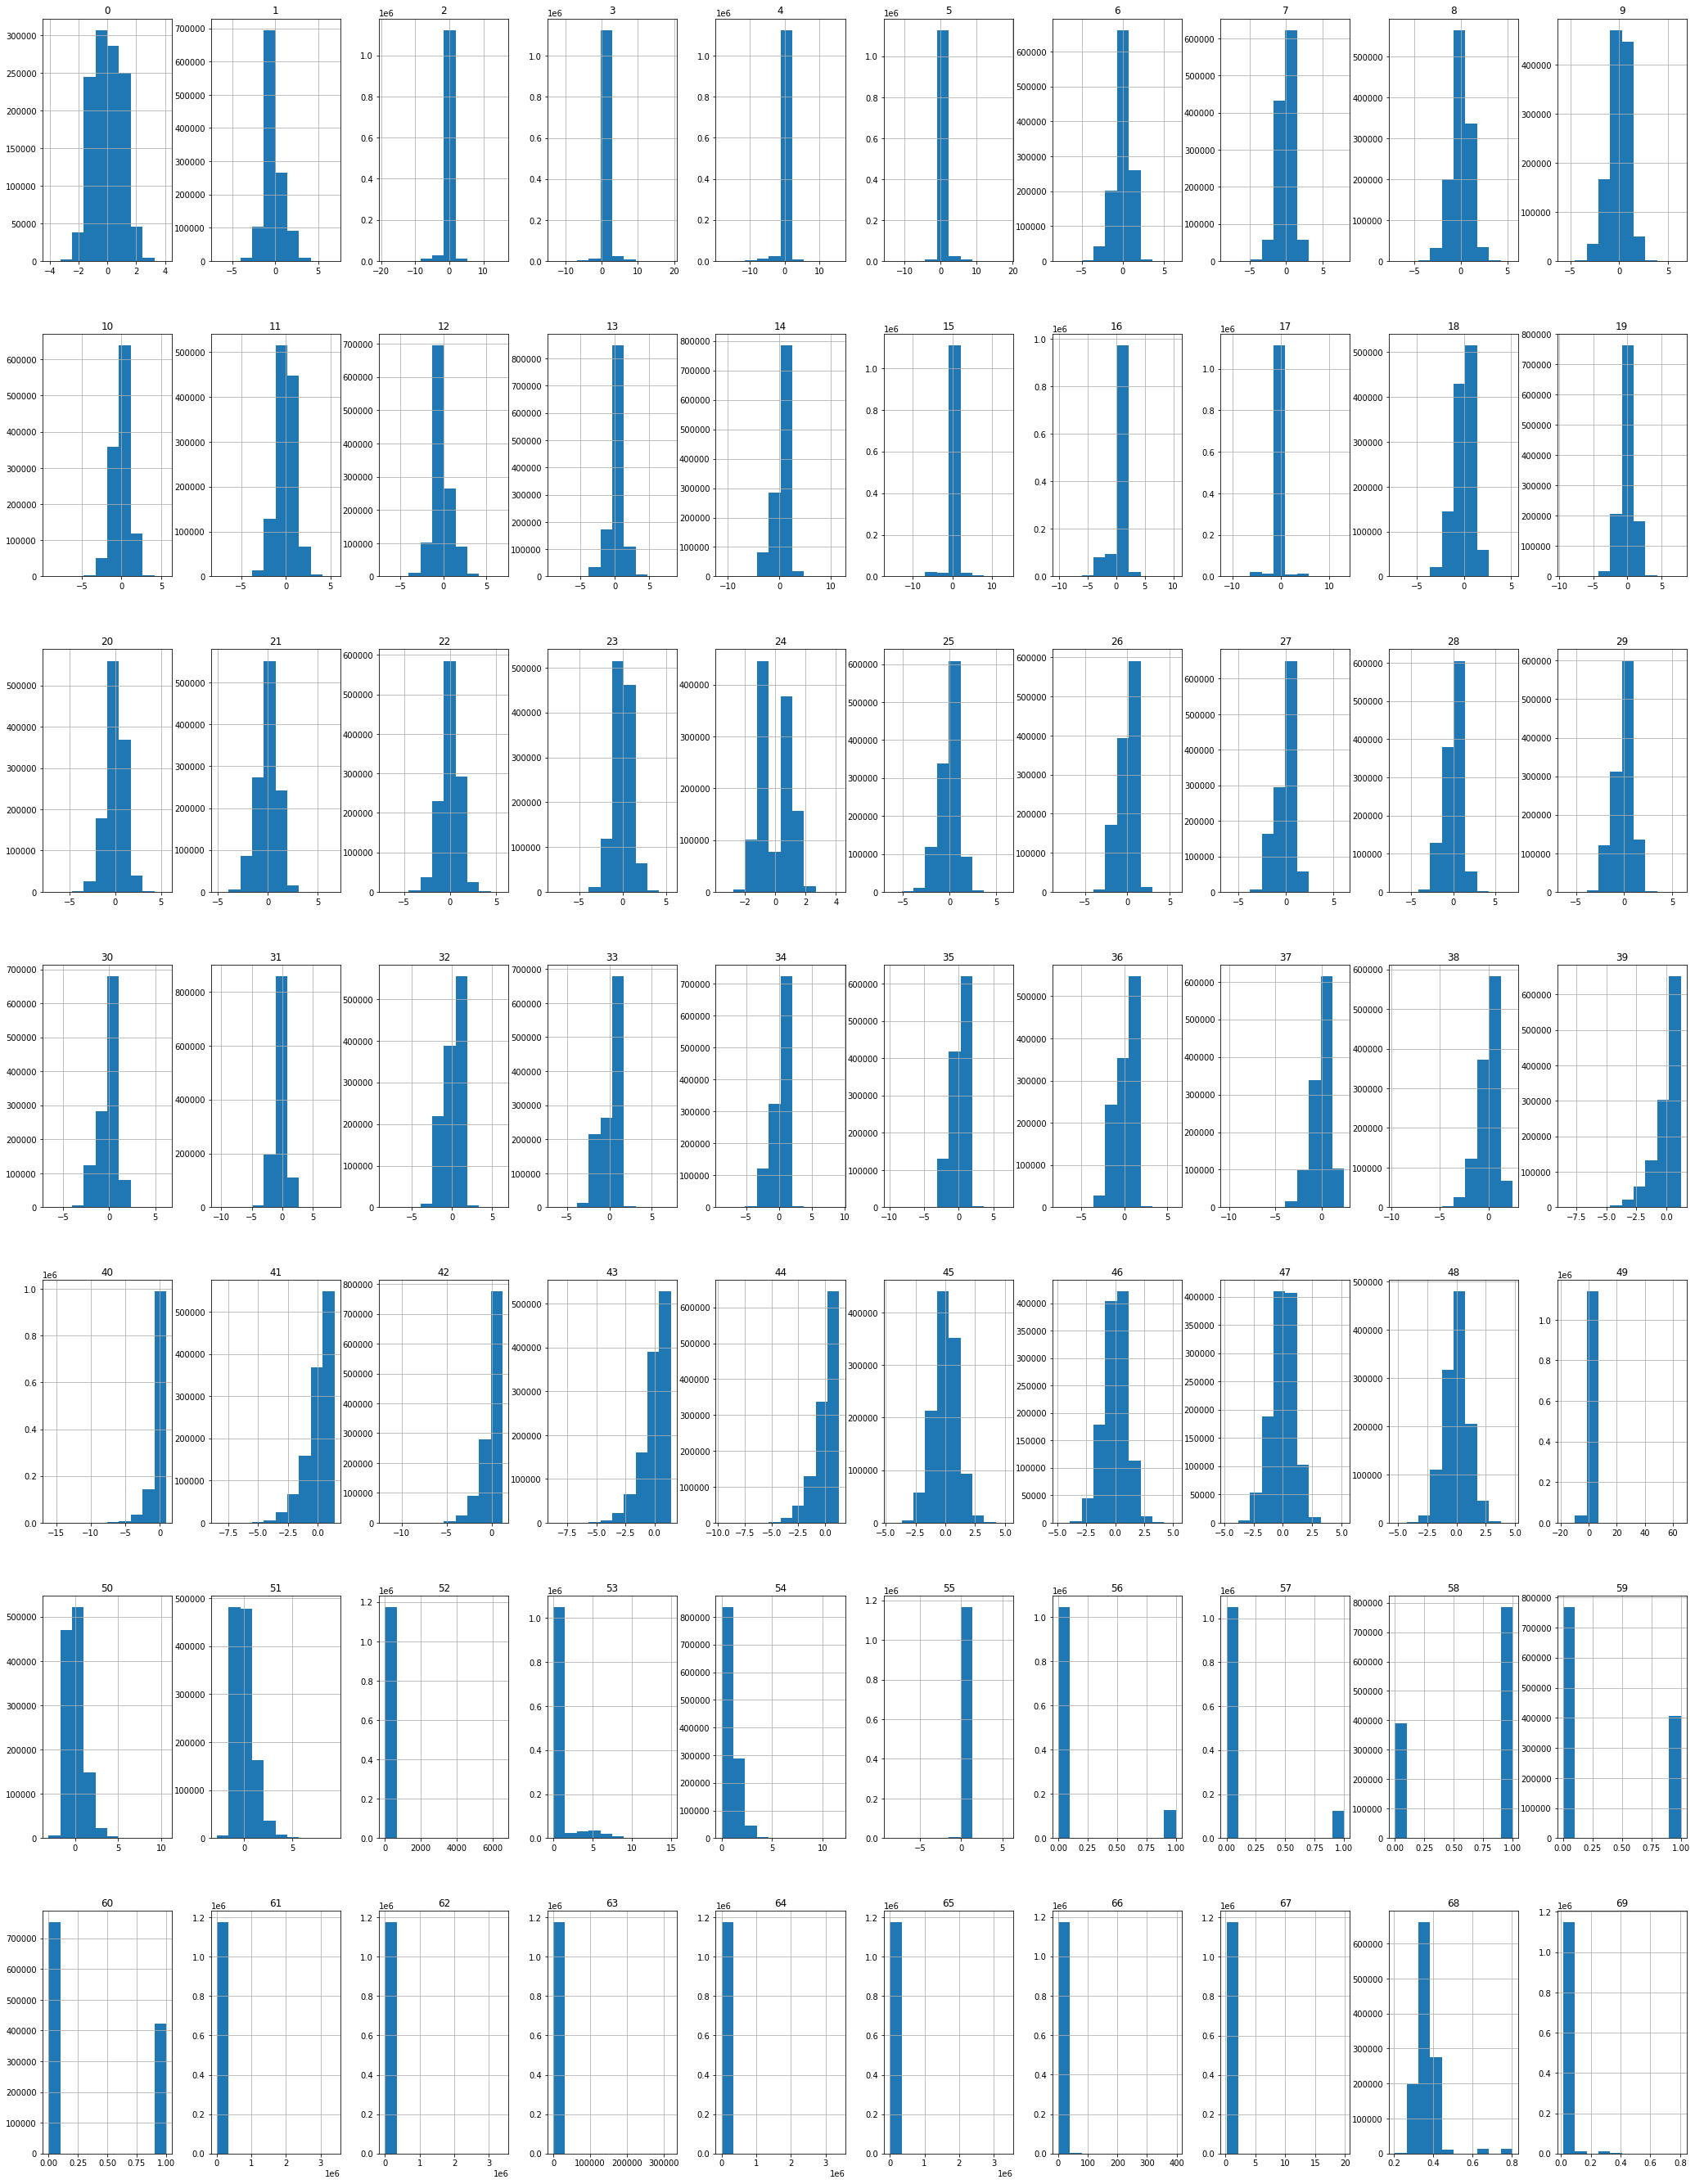

In [9]:
df_hist(train_df)

In [12]:
def corr_remove_col(df, th=0.8):
  df = pd.DataFrame(df)
  corr_matrix = df.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if any(upper[column] > th)]
  print("移除相關性高於於", th, "的欄位：", to_drop)
  return to_drop
def zscore(df):
  scaler = StandardScaler()
  df_scaled = scaler.fit_transform(df)
  return df_scaled
def outlier_remove(df):
  abs_z_scores = np.abs(stats.zscore(df))
  filtered_entries = (abs_z_scores < 3.5).all(axis=1)
  new_df = df[filtered_entries]
  print("移除："'{:.2%}樣本'.format(1-(new_df.shape[0]/df.shape[0])))
  return new_df

In [13]:
drop_col = corr_remove_col(train_df, th=0.8)
train_df = train_df.drop(columns=drop_col)
test_df = test_df.drop(columns=drop_col)

移除相關性高於於 0.8 的欄位： [12, 38, 41, 43, 44, 46, 47, 62, 64, 65]


In [14]:
df_proc = np.column_stack((train_df, train_label))
df_proc = outlier_remove(df_proc)

print(df_proc.shape)

train_df = df_proc[:, :-1]
train_label = df_proc[:, -1]

print(train_df.shape, test_df.shape)

train_df = zscore(train_df)
test_df = zscore(test_df)

print(train_df.shape, test_df.shape)

移除：27.56%樣本
(850749, 61)
(850749, 60) (1175302, 60)
(850749, 60) (1175302, 60)


In [16]:

def conf_matrix_report(y_true, y_pred):  
  conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
  #
  # Print the confusion matrix using Matplotlib
  #
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

  print(classification_report(y_true, y_pred, digits=3))



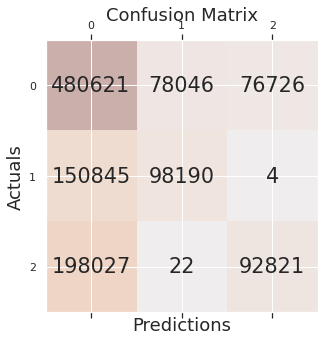

              precision    recall  f1-score   support

           0      0.579     0.756     0.656    635393
           1      0.557     0.394     0.462    249039
           2      0.547     0.319     0.403    290870

    accuracy                          0.571   1175302
   macro avg      0.561     0.490     0.507   1175302
weighted avg      0.567     0.571     0.552   1175302



In [17]:
conf_matrix_report(test_label, ypred_lr)

## XGBoost


In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_label, test_size=0.3, random_state=420)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)
# dtrain = xgb.DMatrix(train_df, label=train_label)
dtest = xgb.DMatrix(test_df, label=test_label)

param = {'max_depth':20, 'eta':0.1,'objective':'multi:softmax', 'num_class':3,'colsample_bytree':0.5, 'eval_metric':'merror'}
num_round = 100
watchlist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=20)

[0]	eval-merror:0.451958	train-merror:0.1573
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 20 rounds.
[1]	eval-merror:0.441023	train-merror:0.079406
[2]	eval-merror:0.431537	train-merror:0.050754
[3]	eval-merror:0.425515	train-merror:0.036526
[4]	eval-merror:0.422004	train-merror:0.026311
[5]	eval-merror:0.417925	train-merror:0.020579
[6]	eval-merror:0.415277	train-merror:0.016668
[7]	eval-merror:0.414125	train-merror:0.013605
[8]	eval-merror:0.411856	train-merror:0.011303
[9]	eval-merror:0.409897	train-merror:0.009291
[10]	eval-merror:0.408236	train-merror:0.008022
[11]	eval-merror:0.407127	train-merror:0.006581
[12]	eval-merror:0.406214	train-merror:0.005614
[13]	eval-merror:0.405391	train-merror:0.004485
[14]	eval-merror:0.404757	train-merror:0.00376
[15]	eval-merror:0.404447	train-merror:0.003214
[16]	eval-merror:0.403605	train-merror:0.002766
[17]	eval-merror:0.402492	train-merror:0.002344


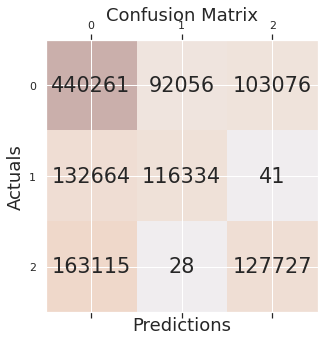

              precision    recall  f1-score   support

           0      0.598     0.693     0.642    635393
           1      0.558     0.467     0.509    249039
           2      0.553     0.439     0.490    290870

    accuracy                          0.582   1175302
   macro avg      0.570     0.533     0.547   1175302
weighted avg      0.579     0.582     0.576   1175302



In [20]:

ypred_xgb = bst.predict(dtest)
conf_matrix_report(test_label, ypred_xgb)

### SMOTE


In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(train_df, train_label)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=420)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)
# dtrain = xgb.DMatrix(train_df, label=train_label)
dtest = xgb.DMatrix(test_df, label=test_label)

param = {'max_depth':20, 'eta':1,'objective':'multi:softmax', 'num_class':3,'colsample_bytree':0.5, 'eval_metric':'merror'}
num_round = 100
watchlist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=20)

[0]	eval-merror:0.308895	train-merror:0.156336
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 20 rounds.
[1]	eval-merror:0.295376	train-merror:0.092882
[2]	eval-merror:0.280444	train-merror:0.054514
[3]	eval-merror:0.272619	train-merror:0.032253
[4]	eval-merror:0.266386	train-merror:0.01891
[5]	eval-merror:0.262891	train-merror:0.013756
[6]	eval-merror:0.26154	train-merror:0.008188
[7]	eval-merror:0.260361	train-merror:0.005547
[8]	eval-merror:0.259277	train-merror:0.00375
[9]	eval-merror:0.257967	train-merror:0.002918
[10]	eval-merror:0.257322	train-merror:0.001496
[11]	eval-merror:0.256281	train-merror:0.000937
[12]	eval-merror:0.255655	train-merror:0.000644
[13]	eval-merror:0.255559	train-merror:0.000371
[14]	eval-merror:0.255138	train-merror:0.00024
[15]	eval-merror:0.254242	train-merror:0.000152
[16]	eval-merror:0.253841	train-merror:0.000105
[17]	eval-merror:0.253375	train-merror:4.9e-05
[1

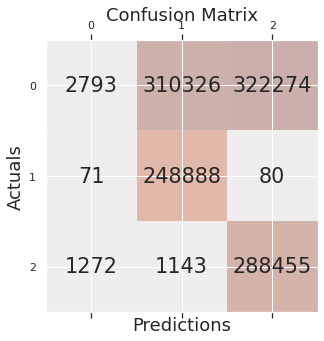

              precision    recall  f1-score   support

           0      0.675     0.004     0.009    635393
           1      0.444     0.999     0.615    249039
           2      0.472     0.992     0.640    290870

    accuracy                          0.460   1175302
   macro avg      0.531     0.665     0.421   1175302
weighted avg      0.576     0.460     0.293   1175302



In [24]:

ypred_xgb_smote = bst.predict(dtest)
conf_matrix_report(test_label, ypred_xgb_smote)

## Hyper Tuning

對於對於XGBoost調整超參數試試看看能不能夠改善模型表現。

In [55]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3)

space={'max_depth': hp.quniform("max_depth", 5, 20, 1),
        'gamma': hp.uniform ('gamma', 1,9),

        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 100,
        'eval_metric':'merror','objective':'multi:softmax', 'num_class':3,
        'seed': 420
    }
def objective(space):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_test, label=y_test)
    num_round = space['n_estimators']

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    param = {'max_depth':int(space['max_depth']), 
             'eta':0.7,
             'objective':'multi:softmax', 
             'num_class':3,
             'colsample_bytree':int(space['colsample_bytree']), 
             'eval_metric':'merror', 
             'min_child_weight': int(space['min_child_weight'])
             }
    bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=10, verbose_eval=False)

    pred = bst.predict(dval)
    accuracy = f1_score(y_test, pred, average='macro')
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# dtrain = xgb.DMatrix(train_df, label=train_label)
# dtest = xgb.DMatrix(test_df, label=test_label)

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

In [ ]:
print(best_hyperparams)

{'colsample_bytree': 0.6661544963218219, 'gamma': 8.709392444417313, 'max_depth': 19.0, 'min_child_weight': 10.0}


In [57]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=420)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test_df, label=test_label)


param = {'max_depth':19, 'eta':1,'objective':'multi:softmax', 'num_class':3,
         'colsample_bytree':0.6661544963218219, 
         'gamma':8.709392444417313,
          'min_child_weight': 10,
         'eval_metric':'merror'}
num_round = 100
watchlist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=10)

[0]	eval-merror:0.304373	train-merror:0.278405
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 10 rounds.
[1]	eval-merror:0.290677	train-merror:0.258106
[2]	eval-merror:0.275245	train-merror:0.23969
[3]	eval-merror:0.268715	train-merror:0.231573
[4]	eval-merror:0.262364	train-merror:0.223969
[5]	eval-merror:0.260849	train-merror:0.220394
[6]	eval-merror:0.259629	train-merror:0.217842
[7]	eval-merror:0.257499	train-merror:0.215102
[8]	eval-merror:0.257516	train-merror:0.213038
[9]	eval-merror:0.256054	train-merror:0.210624
[10]	eval-merror:0.25508	train-merror:0.20894
[11]	eval-merror:0.254264	train-merror:0.207452
[12]	eval-merror:0.254022	train-merror:0.20629
[13]	eval-merror:0.253771	train-merror:0.204926
[14]	eval-merror:0.253496	train-merror:0.204508
[15]	eval-merror:0.252807	train-merror:0.203487
[16]	eval-merror:0.252218	train-merror:0.202445
[17]	eval-merror:0.252302	train-merror:0.201485
[

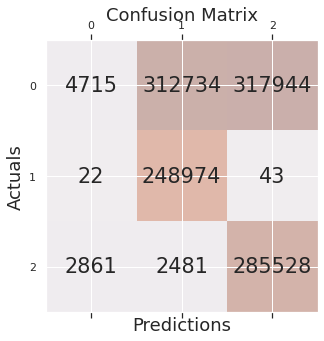

              precision    recall  f1-score   support

           0      0.621     0.007     0.015    635393
           1      0.441     1.000     0.612    249039
           2      0.473     0.982     0.638    290870

    accuracy                          0.459   1175302
   macro avg      0.512     0.663     0.422   1175302
weighted avg      0.546     0.459     0.296   1175302



In [58]:
ypred_xgb_best = bst.predict(dtest)
conf_matrix_report(test_label, ypred_xgb_best)

- recall稍微改善改善
- 不平衡情形稍微改善

### NN

試試看別種演算法（神經網路）進行分類。

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=420)

In [60]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [61]:
class Model(nn.Module):
  def __init__(self, input_dim):
      super(Model, self).__init__()
      self.layer1 = nn.Linear(input_dim, 100)
      self.layer2 = nn.Linear(100, 500)
      self.layer3 = nn.Linear(500, 3)
      
  def forward(self, x):
      x = F.relu(self.layer1(x))
      x = F.relu(self.layer2(x))
      x = F.softmax(self.layer3(x), dim=1)
      return x

model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=60, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=3, bias=True)
)

In [62]:
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [09:12<00:00,  5.52s/it]


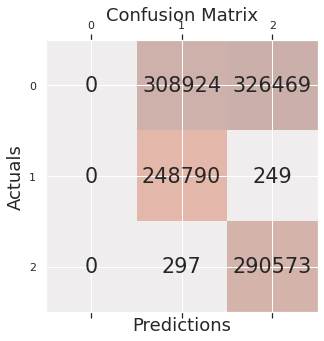

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000    635393
           1      0.446     0.999     0.617    249039
           2      0.471     0.999     0.640    290870

    accuracy                          0.459   1175302
   macro avg      0.306     0.666     0.419   1175302
weighted avg      0.211     0.459     0.289   1175302



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:

ypred_nn=(torch.argmax(model(Variable(torch.from_numpy(test_df)).float()), dim=1))
conf_matrix_report(test_label, ypred_nn)

ROC Curve視覺化

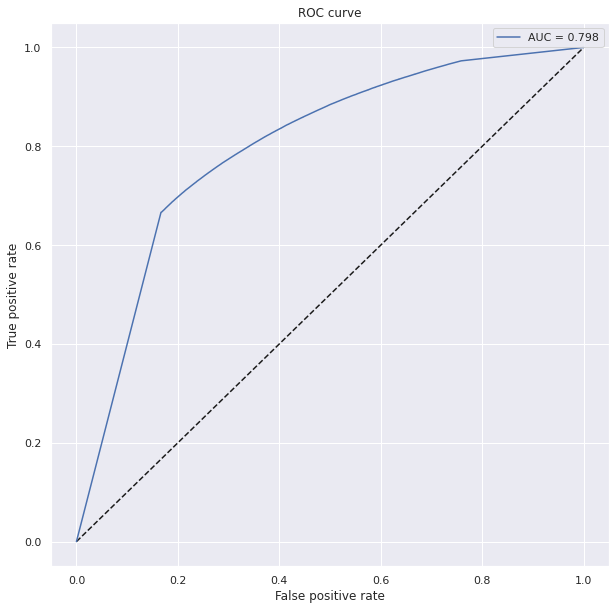

In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();